In [1]:
import torch
import torchvision
# from torch.utils.tensorboard import SummaryWriter
import time
from torch import nn
from torch.utils.data import DataLoader
from load_data import MyData  # self-made
from torchvision import transforms
from tqdm import tqdm_notebook as tqdm # View procedure
import os
import scipy.io
from random import random
import numpy as np
import gc
from torch.utils.tensorboard import SummaryWriter
from network_cnn_lstm import MyNetwork
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Load Test Data

In [2]:
mode_list = ['hc_doc', 'mcs_uws']
exper_dir = "conditionC"
mode = mode_list[0]
root_dir = f"../data/eegmap_split/{exper_dir}"
test_data = []
test_label = []
# ---- hc
if mode == mode_list[0]:
    dataset = MyData(root_dir, f"test", "hc") # hc
    # find the fold file
    for person in range(len(dataset)):
        filename = os.path.join(dataset.path, dataset.file_path[person])
        data_map = torch.load(filename)
#         print(f"data_map size: {data_map.size()}")
        # extract the pure name of the file
        parts = filename.split("\\")
        file_name = parts[-1]
        name_without_extension = file_name.split(".")[0]
        # label or data
        file_last = name_without_extension.split("_")[-1]
        if file_last == "label": # label
            for label in data_map:
                test_label.append(label)
        else: # data
            for data in data_map:
                test_data.append(data)
        del filename, parts, name_without_extension, file_last
        gc.collect()
        torch.cuda.empty_cache()   
# ---- mcs
dataset = MyData(root_dir, "test", "mcs") 
# find the fold file
for person in range(len(dataset)):
    filename = os.path.join(dataset.path, dataset.file_path[person])
    data_map = torch.load(filename)
#     print(f"data_map size: {data_map.size()}")
    # extract the pure name of the file
    parts = filename.split("\\")
    file_name = parts[-1]
    name_without_extension = file_name.split(".")[0]
    # label or data
    file_last = name_without_extension.split("_")[-1]
    if file_last == "label": # label
        for label in data_map:
            test_label.append(label)
    else: # data
        for data in data_map:
            test_data.append(data)
    del filename, parts, name_without_extension, file_last
    gc.collect()
    torch.cuda.empty_cache()  
# ---- uws
dataset = MyData(root_dir, "test", "uws") # uws
# find the fold file
for person in range(len(dataset)):
    filename = os.path.join(dataset.path, dataset.file_path[person])
    data_map = torch.load(filename)
#     print(f"data_map size: {data_map.size()}")
    # extract the pure name of the file
    parts = filename.split("\\")
    file_name = parts[-1]
    name_without_extension = file_name.split(".")[0]
    # label or data
    file_last = name_without_extension.split("_")[-1]
    if file_last == "label": # label
        for label in data_map:
            test_label.append(label)
    else: # data
        for data in data_map:
            test_data.append(data)
    del filename, parts, name_without_extension, file_last
    gc.collect()
    torch.cuda.empty_cache()  
test_data = torch.stack(test_data)
test_label = torch.stack(test_label)
# print(test_data.size())
# print(test_label.size())
test_data_size = test_label.size()

In [3]:
BATCH_SIZE = 1
C,H,W = 1,1,2400
learn_rate = 0.0005
num_epochs = 100

In [4]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
# test dataset
test_td = TensorDataset(test_data, test_label)
test_loader = DataLoader(test_td, batch_size = BATCH_SIZE, shuffle = True)

In [5]:
del test_data
del test_label
del test_td
gc.collect()
torch.cuda.empty_cache()

# 设置随机种子

In [6]:
import random
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
manualSeed = 4
random.seed(manualSeed)
torch.manual_seed(manualSeed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(manualSeed)

# Load Model

In [7]:
import torch.optim as optim
device = torch.device("cuda:0")
gc.collect()
torch.cuda.empty_cache()
# 加载预训练模型!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# 定义LSTM超参数
input_size = 64  # 输入特征维度
hidden_size = 64  # 隐藏单元数量
num_layers = 2  # LSTM层数
output_size = 2  # 输出类别数量

# ==损失函数权重
# condition3-HC/DOC
total_samples = 887 + 975 + 879
weights = [total_samples / 887, total_samples / (975 + 879)]
# condition3-MCS/UWS
# total_samples = 975 + 879
# weights = [total_samples / 975, total_samples / 879]

# 将权重转换为张量
weights_tensor = torch.tensor(weights, device=device)
# 定义交叉熵损失函数并设置权重
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
criterion = criterion.to(device)
# 将权重转换为张量
weights_tensor = torch.tensor(weights, device=device)
# 定义交叉熵损失函数并设置权重
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
criterion = criterion.to(device)
model_list = ['', '_CNN', '_CNN_spa', '_CNN_spa_lstm']
model_name = model_list[0]
if model_name == model_list[0]: #  CascadeCept
    from network_cnn_lstm import MyNetwork
elif model_name == model_list[1]: #  CNN
    from network_cnn_lstm_2 import MyNetwork
elif model_name == model_list[2]: # CascadeCept_1
    from network_cnn_lstm_3 import MyNetwork
elif model_name == model_list[3]: # CascadeCept_2
    from network_cnn_lstm_4 import MyNetwork
fold = 0
begin = 0
end = 56
exper_dir = "conditionC_0"
classification = "hc_doc"
print(f"../model/{classification}/{exper_dir}{model_name}/Fold{fold}.pt")
for i in tqdm(range(begin,end)):
    model = MyNetwork(input_size, hidden_size, num_layers, output_size)
    model.load_state_dict(torch.load(f"../model/{classification}/{exper_dir}{model_name}/Fold{fold}_Epoch{i}.pt"))
    model = model.to(device)
    # 测试步骤开始
    model.eval()
    # 初始化损失和准确率
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    total_test_loss = 0
    # 计数
    test_count = 0
    # 用于绘制混淆矩阵
    predicted_labels = torch.tensor([])
    predicted_labels = predicted_labels.to(device)
    true_labels = torch.tensor([])
    true_labels = true_labels.to(device)
    with torch.no_grad(): # 设置不进行后向传播
        for data in test_loader:
            test_count = test_count + 1
            data_map, label=data # x,y
            # x
            data_map_reshaped = torch.reshape(data_map, (110, 1, 1, 2400))
            data_map_reshaped = data_map_reshaped.to(device)
            # y
            label_int = label.long()
            label_int = label_int.to(device)
            # clear gpu
            del data_map
            del label
            gc.collect()
            torch.cuda.empty_cache()
            # y_pred
            label_pred_test = model(data_map_reshaped)

            # confusion matrix
            predicted_labels = torch.cat((predicted_labels, label_pred_test.argmax(1)), dim=0)
            true_labels = torch.cat((true_labels, label_int), dim=0)

            # loss
            loss = criterion(label_pred_test,label_int)
            total_test_loss = total_test_loss + loss.item()

            pred_label = ((label_pred_test.argmax(1)) == label_int).sum()
            # calculation
            if label_int == 1: # DOC
                if pred_label == 1: # 预测对了
                    TP = TP + 1
                elif pred_label ==0: # 预测错了
                    FN = FN + 1
            if label_int == 0: # HC
                if pred_label == 1: # 预测对了
                    TN = TN + 1
                elif pred_label == 0: # 预测错了
                    FP = FP + 1
    print(f"=====================Epoch {i} == Loss:{total_test_loss}===============")
    print(f"--Accuracy: {(TP + TN) / (TP + TN + FP + FN)}")
    print(f"--Precision: {TP / (TP + FP)}")
    print(f"--Recall: {TP / (TP + FN)}")
    del model,TP,TN,FP,FN,total_test_loss,test_count
    gc.collect()
    torch.cuda.empty_cache()

../model/hc_doc/conditionC_0/Fold0.pt


D:\Anaconda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/56 [00:00<?, ?it/s]

=====================Epoch 0 == Loss:210.47033068328165===============
--Accuracy: 0.75
--Precision: 1.0
--Recall: 0.6303501945525292
=====================Epoch 1 == Loss:19.825156958773732===============
--Accuracy: 0.9894736842105263
--Precision: 0.9922178988326849
--Recall: 0.9922178988326849
=====================Epoch 2 == Loss:70.96535285271239===============
--Accuracy: 0.9394736842105263
--Precision: 0.9875
--Recall: 0.9221789883268483
=====================Epoch 3 == Loss:18.81013248616364===============
--Accuracy: 0.9868421052631579
--Precision: 1.0
--Recall: 0.980544747081712
=====================Epoch 4 == Loss:24.066824188717874===============
--Accuracy: 0.968421052631579
--Precision: 1.0
--Recall: 0.953307392996109
=====================Epoch 5 == Loss:14.3543081170792===============
--Accuracy: 0.9894736842105263
--Precision: 0.996078431372549
--Recall: 0.9883268482490273
=====================Epoch 6 == Loss:9.18100751840393===============
--Accuracy: 0.9868421052631579
-

KeyboardInterrupt: 

# Single Test

In [8]:
import torch.optim as optim
device = torch.device("cuda:0")
gc.collect()
torch.cuda.empty_cache()

# 加载预训练模型!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# 定义LSTM超参数
input_size = 64  # 输入特征维度
hidden_size = 64  # 隐藏单元数量
num_layers = 2  # LSTM层数
output_size = 2  # 输出类别数量

# ==损失函数权重
# ======== 二分类HC/DOC
# 计算总样本数量
# condition1
# total_samples = 887 + 985 + 879
# condition2
# total_samples = 929 + 1029 + 886
# condition3
total_samples = 887 + 975 + 879
# 计算每个类别的权重
# condition1
# weights = [total_samples / 887, total_samples / (985 + 879)]
# condition2
# weights = [total_samples / 929, total_samples / (1029 + 886)]
# condition3
weights = [total_samples / 887, total_samples / (975 + 879)]

# ======== 二分类MCS/UWS
# 计算总样本数量
# condition1
# total_samples = 985 + 879
# condition2
# total_samples = 1029 + 886
# condition3
# total_samples = 975 + 879
# 计算每个类别的权重
# condition1
# weights = [total_samples / 985, total_samples / 879]
# condition2
# weights = [total_samples / 1029, total_samples / 886]
# condition3
# weights = [total_samples / 975, total_samples / 879]

# # 将权重转换为张量
weights_tensor = torch.tensor(weights, device=device)

# # 定义交叉熵损失函数并设置权重
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
# criterion = nn.CrossEntropyLoss()
# criterion = nn.SmoothL1Loss()
criterion = criterion.to(device)

# 用于绘制混淆矩阵和评价指标计算
predict_labels0 = torch.tensor([])
predict_labels0 = predict_labels0.to(device)
true_labels0 = torch.tensor([])
true_labels0 = true_labels0.to(device)
predict_labels1 = torch.tensor([])
predict_labels1 = predict_labels1.to(device)
true_labels1 = torch.tensor([])
true_labels1 = true_labels1.to(device)
predict_labels2 = torch.tensor([])
predict_labels2 = predict_labels2.to(device)
true_labels2 = torch.tensor([])
true_labels2 = true_labels2.to(device)
predict_labels3 = torch.tensor([])
predict_labels3 = predict_labels3.to(device)
true_labels3 = torch.tensor([])
true_labels3 = true_labels3.to(device)
predict_labels4 = torch.tensor([])
predict_labels4 = predict_labels4.to(device)
true_labels4 = torch.tensor([])
true_labels4 = true_labels4.to(device)
from network_cnn_lstm import MyNetwork
# fold0-4
classification = "hc_doc"
# classification = "mcs_uws"
exper_dir = "conditionC_0"
model_list = ['', '_CNN', '_CNN_spa', '_CNN_spa_lstm']
model_select = 0
model_name = model_list[model_select]
if model_name == model_list[0]: #  CascadeCept
    from network_cnn_lstm import MyNetwork
elif model_name == model_list[1]: #  CNN
    from network_cnn_lstm_2 import MyNetwork
elif model_name == model_list[2]: # CascadeCept_1
    from network_cnn_lstm_3 import MyNetwork
elif model_name == model_list[3]: # CascadeCept_2
    from network_cnn_lstm_4 import MyNetwork
model_num = [
    [14,15,10,10],
    [10,16,15,11],
    [14,13,10,11],
    [16,14,10,10],
    [23,9,9,11]
]
for fold in tqdm(range(5)):
#     初始化损失和准确率
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    total_test_loss = 0
    # 计数
    test_count = 0
    # 加载测试所用的模型
    model = MyNetwork(input_size, hidden_size, num_layers, output_size)
    model.load_state_dict(torch.load(f"../model/{classification}/{exper_dir}{model_name}/Fold{fold}_Epoch{model_num[fold][model_select]}.pt"))
    model = model.to(device)
    # 测试步骤开始
    model.eval()
    with torch.no_grad(): # 设置不进行后向传播
        for data in test_loader:
            test_count = test_count + 1
            data_map, label=data # x,y
            # x
            data_map_reshaped = torch.reshape(data_map, (110, 1, 1, 2400))
            data_map_reshaped = data_map_reshaped.to(device)
            # y
            label_int = label.long()
            label_int = label_int.to(device)
            # clear gpu
            del data_map
            del label
            gc.collect()
            torch.cuda.empty_cache()
            # y_pred
            label_pred_test = model(data_map_reshaped)

            # confusion matrix
            if fold == 0:
                predict_labels0 = torch.cat((predict_labels0, label_pred_test.argmax(1)), dim=0)
                true_labels0 = torch.cat((true_labels0, label_int), dim=0)
            elif fold == 1:
                predict_labels1 = torch.cat((predict_labels1, label_pred_test.argmax(1)), dim=0)
                true_labels1 = torch.cat((true_labels1, label_int), dim=0)
            elif fold == 2:
                predict_labels2 = torch.cat((predict_labels2, label_pred_test.argmax(1)), dim=0)
                true_labels2 = torch.cat((true_labels2, label_int), dim=0)
            elif fold == 3:
                predict_labels3 = torch.cat((predict_labels3, label_pred_test.argmax(1)), dim=0)
                true_labels3 = torch.cat((true_labels3, label_int), dim=0)
            elif fold == 4:
                predict_labels4 = torch.cat((predict_labels4, label_pred_test.argmax(1)), dim=0)
                true_labels4 = torch.cat((true_labels4, label_int), dim=0)
            

            # loss
            loss = criterion(label_pred_test,label_int)
            total_test_loss = total_test_loss + loss.item()
            pred_label = ((label_pred_test.argmax(1)) == label_int).sum()
            # calculation
            if label_int == 1: # DOC
                if pred_label == 1: # 预测对了
                    TP = TP + 1
                elif pred_label ==0: # 预测错了
                    FN = FN + 1
            if label_int == 0: # HC
                if pred_label == 1: # 预测对了
                    TN = TN + 1
                elif pred_label == 0: # 预测错了
                    FP = FP + 1
        print(f"===================== Fold{fold}，Loss:{total_test_loss} ===============")
        print(f"--Accuracy: {(TP + TN) / (TP + TN + FP + FN)}")
        print(f"--Precision: {TP / (TP + FP)}")
        print(f"--Recall: {TP / (TP + FN)}")
        del model,TP,TN,FP,FN,total_test_loss,test_count
        gc.collect()
        torch.cuda.empty_cache()

D:\Anaconda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:99: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/5 [00:00<?, ?it/s]

===================== Fold0，Loss:3.5718817556720523 ===============
--Accuracy: 0.9973684210526316
--Precision: 0.9961240310077519
--Recall: 1.0
===================== Fold1，Loss:112.01225193490973 ===============
--Accuracy: 0.8947368421052632
--Precision: 0.8861209964412812
--Recall: 0.9688715953307393
===================== Fold2，Loss:3.352482262409467 ===============
--Accuracy: 0.9973684210526316
--Precision: 0.9961240310077519
--Recall: 1.0
===================== Fold3，Loss:5.075340037340851 ===============
--Accuracy: 0.9947368421052631
--Precision: 1.0
--Recall: 0.9922178988326849
===================== Fold4，Loss:65.93295669201835 ===============
--Accuracy: 0.9815789473684211
--Precision: 0.996031746031746
--Recall: 0.9766536964980544


# Draw 

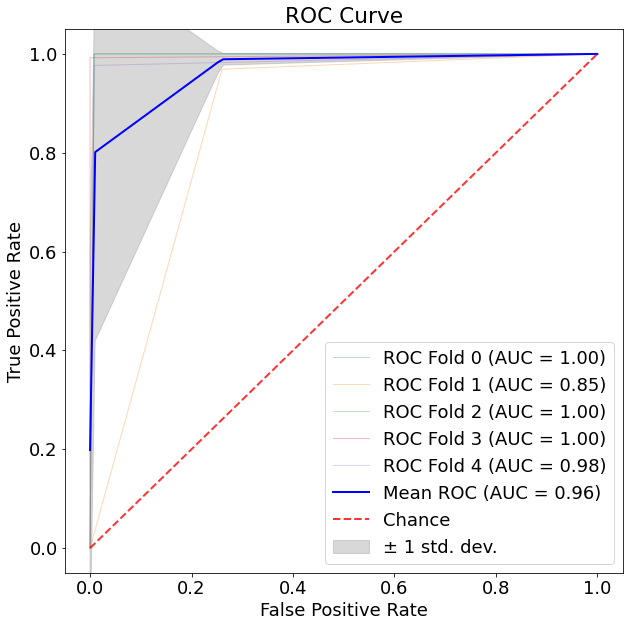

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 设置全局字体大小
plt.rcParams.update({'font.size': 18})  # 设置字体大小
# 假设有五个模型的预测概率和真实标签
predict_labels_list = [predict_labels0, predict_labels1, predict_labels2, predict_labels3, predict_labels4]
true_labels_list = [true_labels0, true_labels1, true_labels2, true_labels3, true_labels4]
for pred in range(len(predict_labels_list)):
    predict_labels_list[pred] = predict_labels_list[pred].cpu().numpy()
for true_label in range(len(true_labels_list)):
     true_labels_list[true_label]= true_labels_list[true_label].cpu().numpy()
# 初始化绘图
plt.figure(figsize=(10, 10))

# 存储每个fold的假正率（fpr）和真正率（tpr）
mean_fpr = np.linspace(0, 1, 100)
tprs = []

# 遍历每个fold的预测结果和真实标签
for i, (predict_labels, true_labels) in enumerate(zip(predict_labels_list, true_labels_list)):
    # 计算 ROC 曲线
    fpr, tpr, _ = roc_curve(true_labels, predict_labels)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)

    # 绘制当前fold的ROC曲线
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC Fold {i} (AUC = {roc_auc:.2f})')

# 计算所有fold的均值和标准差
mean_tpr = np.mean(tprs, axis=0)
std_tpr = np.std(tprs, axis=0)

# 绘制所有fold的平均ROC曲线
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f})', lw=2)

# 绘制ROC曲线的标准差区域
plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='grey', alpha=0.3, label='± 1 std. dev.')

# 绘制对角线
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)

# 设置图形属性
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

plt.show()


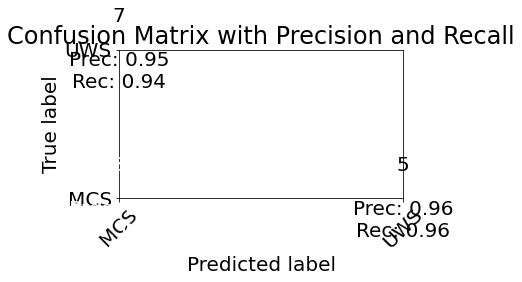

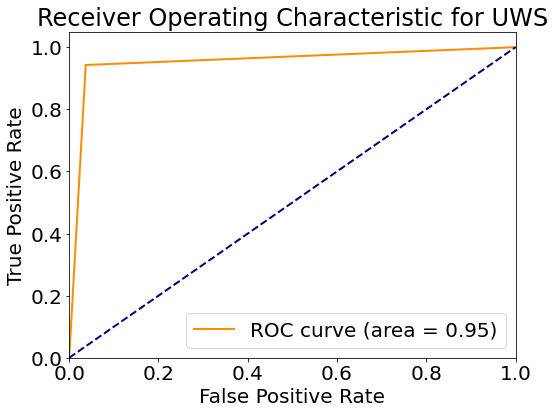

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, auc
# 定义LSTM超参数
input_size = 64  # 输入特征维度
hidden_size = 64  # 隐藏单元数量
num_layers = 2  # LSTM层数
output_size = 2  # 输出类别数量
# fold0-4
exper_dir = "hc_doc"
# exper_dir = "mcs_uws"
model_name = "_CNN"
# model_name = "_CNN"
# model_name = "_CNN_spa"
# model_name = "_CNN_spa_lstm"

# 设置全局字体大小
plt.rcParams.update({'font.size': 20})  # 设置字体大小为 14
# 假设有模型的预测结果和真实标签
# 例如，假设模型预测的结果存储在名为 predicted_labels 的数组中，
# 真实标签存储在名为 true_labels 的数组中
# 将张量转换为 NumPy 数组
# predict_labels = predict_labels.cpu().numpy()
# predict_labels = predict_labels.numpy()
# true_labels = true_labels.cpu().numpy()

# # 计算混淆矩阵
conf_matrix = confusion_matrix(true_labels, predict_labels)

# 计算精确率和召回率
# 注意：在这里，MCS 是标签 0，UWS 是标签 1
precision = precision_score(true_labels, predict_labels, labels=[0, 1], average=None)
recall = recall_score(true_labels, predict_labels, labels=[0, 1], average=None)

# # 绘制混淆矩阵
# plt.figure(figsize=(10, 8))  # 设置图形大小
# plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
# plt.colorbar()

# 标记轴和标签
classes = ['MCS', 'UWS']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# 添加数值标签和精确率/召回率信息（保持字体大小一致）
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, f'{conf_matrix[i, j]}\n\nPrec: {precision[j]:.2f}\nRec: {recall[i]:.2f}',
                 horizontalalignment="center",
                 verticalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix with Precision and Recall')
plt.show()

# 计算病例级别的分类概率
# 假设 p_i 是每个病例被分类为 MCS 的概率
# true_labels 中包含每个样本的真实标签，predicted_labels 中包含每个样本的预测标签
p_mcs = np.sum(predict_labels == 0) / len(true_labels)
p_uws = 1 - p_mcs

# 绘制 ROC 曲线
# 注意：这里计算 ROC 曲线的输入应该是真实标签和预测概率，而不是单个概率值 p_mcs
fpr, tpr, _ = roc_curve(true_labels, predict_labels)  # 根据预测概率计算 ROC
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))  # 设置 ROC 曲线图形大小
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for UWS')
plt.legend(loc='lower right')
plt.show()

# Draw Confusion Matrix

In [12]:
# ConditionB
# model.load_state_dict(torch.load(f"../model/{exper_dir}/Fold3_Epoch19.pt")) # !!!!!!!!!!!!!!!!!!!!!
# model.load_state_dict(torch.load(f"../model/{exper_dir}/Fold4_Epoch11.pt"))

# ConditionC
# model.load_state_dict(torch.load(f"../model/{exper_dir}/Fold0_Epoch19.pt"))
# model.load_state_dict(torch.load(f"../model/{exper_dir}/Fold1_Epoch28.pt"))
# model.load_state_dict(torch.load(f"../model/{exper_dir}/Fold2_Epoch27.pt"))
# model.load_state_dict(torch.load(f"../model/{exper_dir}/Fold3_Epoch50.pt"))
# 假设有模型的预测结果和真实标签
#例如，假设模型预测的结果存储在名为 predicted_labels 的张量中，
# 真实标签存储在名为 true_labels 的张量中
# predicted_labels = torch.tensor([0, 1, 2, 1, 0, 2])
# true_labels = torch.tensor([0, 1, 2, 1, 0, 1])

# 将张量转换为 NumPy 数组
predict_labels = predict_labels.cpu().numpy()
true_labels = true_labels.cpu().numpy()

# 计算混淆矩阵
conf_matrix = confusion_matrix(true_labels, predict_labels)

# 绘制混淆矩阵
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.colorbar()

# 标记轴和标签
classes = ['MCS', 'UWS']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# 添加数值标签
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()


AttributeError: 'numpy.ndarray' object has no attribute 'cpu'